In [1]:
import numpy as np
from sklearn.datasets import load_sample_images
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from utility import *
import cv2
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/bzr0014/envs/AI/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors', 'log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
pylab.rcParams['figure.figsize'] = (10, 9)
def threshold(img, low, high, label):
    w, h, d = img.shape
    masks = []
    for i in range(3):
        masks.append(img[:, :, i] <= high[i])
        masks.append(img[:, :, i] >= low[i])
    #masks.append(img[:, :, 2] > 200)
    mask = np.ones((w, h))
    for m in masks:
        mask *= m   
    return(mask * label)
def preprocess_label(label):
    m1 = threshold(label, [0, 0, 0], [1, 1, 255], 1)
    m2 = threshold(label, [240, 0, 0], [255, 30, 255], 2)
    m3 = threshold(label, [255, 255, 255], [255, 255, 255], 3)
    m = m1 + m2 + m3
    m = cv2.erode(m, np.ones((3, 3)))
    return m


In [3]:
def preprocess_image(img, n=5, k=3):
    img_gray = img.mean(axis=2)
    masks = []
    masks.append(img[:, :, 0] >= 240)
    masks.append(img[:, :, 1] <= 200)
    #masks.append(img[:, :, 2] > 200)
    mask = np.ones_like(img_gray)
    for m in masks:
        mask *= m

    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(mask,kernel,iterations = 1)

    n = 10
    N = n * 2  +1
    k = 3
    kernel = np.ones((N, N), dtype='float32') / (N * N - k*k)
    kernel[n+1-k//2:n+2+k//2, n:n+3] = 0
    kernel = kernel.reshape(1, N*N)
    indices = np.where(dilation)
    new_img = img_gray.copy()
    for i in range(5):
        for i, j in zip(indices[0], indices[1]):
            new_img[i, j] = np.dot(kernel, new_img[i-n:i+n+1, j-n:j+n+1].reshape(N*N, 1))
            #new_img[i, j] = np.median(new_img[i-n:i+n+1, j-n:j+n+1])

    new_img = cv2.GaussianBlur(new_img,(9,9),0)
    #new_img = cv2.medianBlur(new_img, 9)
    return new_img

In [4]:
neighSize = 21
img_shape = (200, 100)
def convert_images(new_img, m, neighSize=neighSize, img_shape=img_shape):
    original = cv2.resize(new_img, img_shape)
    marks = cv2.resize(m, img_shape)
    w, h = original.shape
    numNeighInRows = w - neighSize + 1
    X = []
    y = []
    for i in range(w-neighSize+1):
        X_tmp = []
        y_tmp = []
        for j in range(h-neighSize+1):
            X_tmp.append(original[i:i+neighSize, j:j+neighSize])
            y_tmp.append(marks[i:i+neighSize, j:j+neighSize])
        X.append(X_tmp)
        y.append(y_tmp)

    #assert(X.shape == (w-neighSize+1, h-neighSize+1, neighSize, neighSize))
    #assert(X.shape == y.shape)
    return X, y


In [5]:
import os
w_cut = 150 
h_cut = 200 
# Set the directory you want to start from
img_dir = '/home/bzr0014/git/sesek2/Behnam Files/original/'
tag_dir = '/home/bzr0014/git/sesek2/Behnam Files/tagged/'
Xs = []
ys = []
num_images = 0
for dirName, subdirList, fileList in os.walk(img_dir):
    print('Found directory: %s' % dirName)
    for fname in fileList:
        if fname.endswith('.tif'):
            print('\t%s' % fname)
            main_name = fname.split('.')[0]
            img = plt.imread(img_dir+fname)[w_cut:-w_cut, h_cut:-h_cut]
            label = plt.imread(tag_dir+main_name+'.jpg')[w_cut:-w_cut, h_cut:-h_cut]
            new_img = preprocess_image(img)
            #imshow(new_img)
            #plt.show()
            m = preprocess_label(label)
            #imshow(m)
            X, y = convert_images(new_img, m)
            Xs.append(X)
            ys.append(y)
            num_images += 1

Found directory: /home/bzr0014/git/sesek2/Behnam Files/original/
	M010-MFC.tif
	M004-MS.tif
	M008-MFC.tif
	M009-MFC.tif
	M003-MFC.tif
	M007-MFC.tif
	M010-MS.tif
	M008-MS.tif
	M002-MS.tif
	M004-MFC.tif
	M005-MFC.tif
	M005-MS.tif
	M006-MS.tif
	M001-MS.tif
	M007-MS.tif
	M009-MS.tif
	M001-MFC.tif
	M002-MFC.tif
	M006-MFC.tif
	M003-MS.tif


In [20]:
print('number of images: %d'%num_images)
X = np.array(Xs)
X = (X - X.mean(axis=(1, 2, 3, 4), keepdims=True)) / X.std(axis=(1, 2, 3, 4), keepdims=True)
y = np.array(ys)
print('Shape of X:', X.shape)

number of images: 20
Shape of X: (20, 80, 180, 21, 21)


image number 1
(101, 201)
(101, 201)


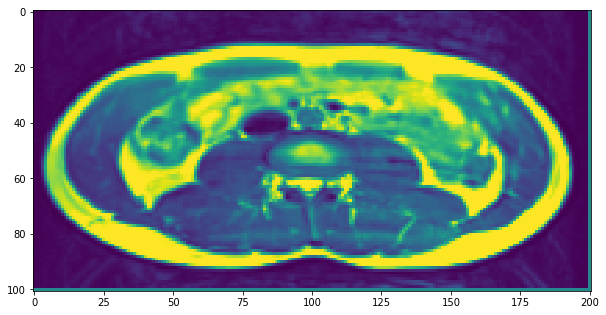

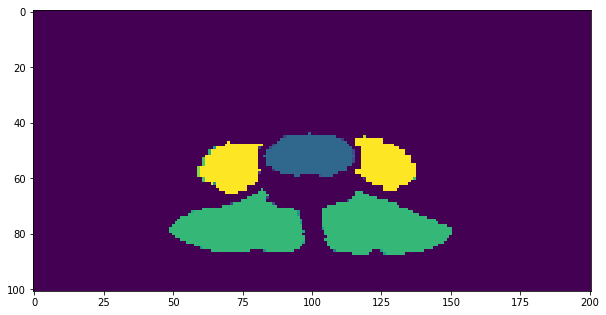

In [21]:
def reconstruct(y):
    a, b, c, d = y.shape
    reconstructed = np.zeros((a+c, b+d))
    for i in range(a):
        for j in range(b):
            reconstructed[i:i+neighSize, j:j+neighSize] = y[i, j]
    return reconstructed
index = np.random.randint(num_images)
print('image number %d'%index)
y_reconstructed = reconstruct(y[index])
X_reconstructed = reconstruct(X[index])
print(y_reconstructed.shape)
print(X_reconstructed.shape)
assert(y_reconstructed.shape == X_reconstructed.shape)
imshow(X_reconstructed)
plt.show()
imshow(y_reconstructed)

In [22]:
print("size of original X:", X.shape)
N, ww, hh, dd1, dd2 = X.shape
X = X.reshape(N, ww * hh, dd1, dd2, 1)
y = y.reshape(N, ww * hh, dd1, dd2, 1)
train_index = int(num_images * .8)
print(train_index)
X_train = X[:train_index].reshape(-1, dd1, dd2, 1)
y_train = y[:train_index].reshape(-1, dd1, dd2)[:, neighSize//2, neighSize//2]
print('size of trainig image: ', X_train.shape)
X_val = X[train_index:].reshape(-1, dd1, dd2, 1)
y_val = y[train_index:].reshape(-1, dd1, dd2)[:, neighSize//2, neighSize//2]
print('size of test image: ', X_val.shape)

size of original X: (20, 80, 180, 21, 21)
16
size of trainig image:  (230400, 21, 21, 1)
size of test image:  (57600, 21, 21, 1)


In [23]:

layer_1_filter_size = 3
layer_1_filter_num = 20
layer_1_stride = 1
layer_2_filter_size = 5
layer_2_filter_num = 20
layer_2_stride = 1
layer_3_filter_num = 20
layer_3_filter_size = 7
layer_3_stride = 1
layer_3_dropout_rate = .25

n_fc1 = 128
fc1_dropout_rate = .5

n_outputs = 4
output_shape = layer_3_filter_num * \
    (neighSize-layer_1_filter_size-layer_2_filter_size-layer_3_filter_size+3)**2

tf.reset_default_graph()

print("output shape:", output_shape)

with tf.name_scope('inputs'):
    X_tf = tf.placeholder(tf.float32, [None, neighSize, neighSize, 1])
    y_tf = tf.placeholder(tf.int64, [None])
    punishment1 = tf.ones_like(y_tf)
    punishment2 = tf.ones_like(y_tf) * 10
    punishment = tf.cast(tf.where(y_tf == 0, punishment1, punishment2), tf.float32)
    training = tf.placeholder_with_default(False, shape=[], name='training')    
    
with tf.name_scope('convs'):
    conv1 = tf.layers.conv2d(X_tf, filters=layer_1_filter_num, kernel_size=layer_1_filter_size,\
                             strides=layer_1_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv1')
    conv2 = tf.layers.conv2d(X_tf, filters=layer_2_filter_num, kernel_size=layer_2_filter_size,\
                             strides=layer_2_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv2')
    conv3 = tf.layers.conv2d(X_tf, filters=layer_3_filter_num, kernel_size=layer_3_filter_size,\
                             strides=layer_3_stride, padding='SAME',\
                             activation=tf.nn.relu, name='conv3')   
with tf.name_scope('skip'):
    #skip = conv3 + X_tf
    skip = tf.concat([conv3, X_tf], axis=3)
    print(skip)
    skip_drop = tf.layers.dropout(skip, rate=layer_3_dropout_rate, training=training)
    skip_flat = tf.reshape(skip_drop, shape=[-1, neighSize*neighSize*(layer_3_filter_num+1)])

with tf.name_scope('fc1'):
    fc1 = tf.layers.dense(skip_flat, n_fc1, activation=tf.nn.relu, name='fc1')
    fc1_drop = tf.layers.dropout(fc1, rate=fc1_dropout_rate, training=training)

with tf.name_scope('output'):
    logits = tf.layers.dense(fc1_drop, n_outputs, name='output')
    y_prob = tf.nn.softmax(logits, name='y_prob')

with tf.name_scope('training'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y_tf)
    loss = tf.reduce_mean(xentropy)# * punishment)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y_tf, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope('init_and_save'):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

output shape: 1620
Tensor("skip/concat:0", shape=(?, 21, 21, 21), dtype=float32)


In [24]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

In [25]:
n_epochs = 1000
batch_size = 100
train_indicies = np.arange(X_train.shape[0])

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 30
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        np.random.shuffle(train_indicies)
        acc_trains = []
        for iteration in range(int(math.ceil(X_train.shape[0]/batch_size))):
            start_idx = (iteration*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            X_batch = X_train[idx, :]
            y_batch = y_train[idx]
            _, batch_acc = sess.run([training_op, accuracy], feed_dict={X_tf: X_batch, y_tf: y_batch, training: True})
            acc_trains.append(batch_acc)

        
        #acc_train = accuracy.eval(feed_dict={X_tf: X_train[train_indicies[:1000]], y_tf: y_train[train_indicies[:1000]]})
        acc_train = np.mean(acc_trains)
        
        acc_tests = []
        losses = []
        for iteration in range(int(math.ceil(X_val.shape[0]/batch_size))):
            batch_acc, batch_loss = sess.run([accuracy, loss], \
                                             feed_dict={X_tf: X_val[iteration*batch_size:(iteration+1)*batch_size],
                                                        y_tf: y_val[iteration*batch_size:(iteration+1)*batch_size]})
            acc_tests.append(batch_acc)
            losses.append(batch_loss)
            
            
        acc_val = np.mean(acc_tests) 
        loss_val = np.mean(losses)
        
        if loss_val < best_loss_val:
            best_loss_val = loss_val
            check_since_last_progress = 0
            best_model_params = get_model_params()
        else:
            checks_since_last_progress += 1       
        print(epoch, "Train accuracy:", acc_train, "loss:", loss_val)
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break
        save_path = saver.save(sess, "./kiri")
        
    if best_model_params:
        restore_model_params(best_model_params)
    acc_test = accuracy.eval(feed_dict={X_tf: X_train, y_tf: y_train})
    print("Final accuracy on test set:", acc_test)
    save_path = saver.save(sess, "./kiri")

0 Train accuracy: 0.8963021 loss: 0.14142959


KeyboardInterrupt: 

INFO:tensorflow:Restoring parameters from ./kiri


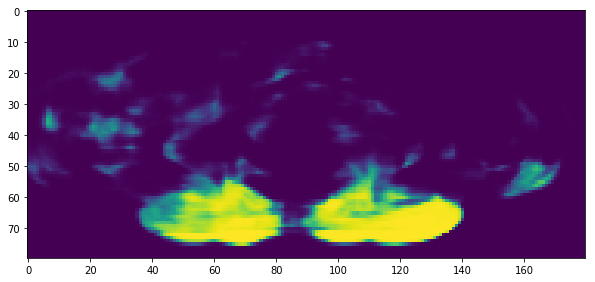

In [28]:
with tf.Session() as sess:
    saver.restore(sess, './kiri')
    output = y_prob.eval(feed_dict={X_tf:X[16].reshape(-1, neighSize, neighSize, 1)})[:, 2].reshape(ww, hh)
    #output = y_prob.eval(feed_dict={X_tf:X_train[train_indicies[:1000]]})
imshow(output)